# Introduction
This script should calculate a pairwise distance matrix based on the CRISPR arrays.
It is an adaptation of the method in Kupczok and Bollack 2013*

*Kupczok, A., and Bollback, J.P. 2013. Probabilistic models for CRISPR spacer content evolution. BMC Evolutionary Biology 13(1): 54. doi:10.1186/1471-2148-13-54.


## From the paper
1. Estimate a starting ρ from the length model by maximum likelihood. 
2. For each pair of spacers with overlap, generate the
    possible ancestors (doesnt need to actually generate the arrays): Ancestral arrays can be arbitrarily
    large, but the probability of observing a certain
    length is given by p(n). For practical reasons we do
    not consider ancestors whose length is outside the
    central 99% of the stationary distribution given by ρ
    estimated in step 1, since they would have a
    negligible contribution to the likelihood. In detail, the
    length l1 where the cumulative distribution exceeds
    0.005 is the minimum ancestor length and the length
    l2 where the cumulative distribution exceeds 0.995 is
    the maximum ancestor length. Then the possible
    ancestor lengths n are between l1 and l2: l1 ≤ n ≤ l2.
3. (a) For all pairs with overlap, estimate the times
    with fixed ρ. It is possible to iterate through
    the pairs and estimate their times
    independently of the other pairs. The
    estimation of both times is iterated
    alternatingly until the likelihood has
    converged.
    (b) Estimate ρ with fixed times using L(ρ|t, S).
    (c) Check if the log-likelihood of the estimated
    parameters has converged, then return the
    estimated parameters, else repeat step (a)
    with the new parameters.

## Pseudo code

functions:
Amongst the spacers, find each pair of spacers with overlap
Generate the possible ancestors of a pair
Estimate time divergence given fixed p 
Estimate p given fixed divergence time


# Find pairs with overlap

In [161]:
ancestor=[0,1,2,3,4,5,6,7,8,9,10,11,12,13]
arr=[[9,2,3,4,5],[0,1,2,3,7,8],[1,10,11,12,13]]
# Deconstruct array into fragments
array1=arr[0]
array2=arr[1]    

def is_overlapping(array1, array2):
    for i in array1:
        if i in array2:
            answer=1
            break
        else:
            answer=0
            continue
    return(answer)

is_overlapping(array1, array2)    

1

# 

## Ordered model:
Given a pair of arrays s1 and s2, find the
first shared spacer. The ancestor must contain this spacer
and all subsequent spacers from both arrays, these are c
spacers in total. There are d1 and d2 spacers before the
first shared spacer in s1 and s2, respectively. With these
new definitions of c, d1 and d2, the method from the
unordered model is applied.

In [1]:
'''Given a pair of arrays s1 and s2, find the
first shared spacer. The ancestor must contain this spacer
and all subsequent spacers from both arrays, these are c
spacers in total. There are d1 and d2 spacers before the
first shared spacer in s1 and s2, respectively. With these
new definitions of c, d1 and d2, the method from the
unordered model is applied.'''

def categorize_spacers_for_ordered_model(s1,s2):
    c_spacers=[]
    for i in range(len(s1)):
        sp=s1[i]
        if sp in s2:
            j=s2.index(sp)
            c_spacers=s2[j:]+s1[i:]
            d1_spacers=s1[:i]
            d2_spacers=s2[:j]
            break
    return(list(set(c_spacers)),d1_spacers,d2_spacers)

arr=[[9,2,3,4,5],[0,1,2,3,7,8],[1,10,11,12,13]]
s1=arr[0]
s2=arr[1]
print('s1',s1)
print('s2',s2)
#first spaer of shorter array

c_spacers, d1_spacers, d2_spacers = categorize_spacers_for_ordered_model(s1,s2)           
print('c_spacers',c_spacers)
print('d1_spacers',d1_spacers)
print('d2_spacers',d2_spacers)

s1 [9, 2, 3, 4, 5]
s2 [0, 1, 2, 3, 7, 8]
c_spacers [2, 3, 4, 5, 7, 8]
d1_spacers [9]
d2_spacers [0, 1]


Then all n between min(c, l1) and l2 are generated.
When length n is generated, enumerate all i, j, u
such that c + i + j + u = n, i ≤ d1 and j ≤ d2. Then for
ancestor a, there are c common spacers, i only occur in s1, j
only occur in s2 and u are unobserved (they are lost in both
lineages).

# Independent loss models : Length model
ro = $$\rho = \frac{\lambda}{\mu}$$
with $\lambda$ = spacer insertion rate, $\mu$ = spacer_deletion_rate

prob_n_given_ro = $$p(n|\rho) = e^{-\rho} \frac{\rho^n}{n!}$$

In [ ]:
import numpy as np

lbda=1
mu=2
n=2

def rho(lbda,mu):
    return(lbda/mu)
def prob_n_given_ro(n,rho):
    return((np.e**-rho)*(rho**n/np.math.factorial(n))) 

In [ ]:
import numpy as np
import pandas as pd

rho=0.2
N = 100
x = map(int,np.linspace(0,20,N))
ϵ = np.random.normal(loc = 0.0, scale = 5.0, size = N)
y = [prob_n_given_ro(n,rho) for n in x]

df = pd.DataFrame({'y':y, 'x':x})
df[:5]

In [2]:
#### define combi class ####
class combi:
    
    """The combi object is a list of integers [c,i,j,u] that represent all putative ancestors given the following parameters:
    c = number of c_spacers; spacers necessarily present in the ancestor of two CRISPR arrays,
    i = number of putative ancestral spacers amongst the spacers only present in array1,
    j = number of putative ancestral spacers amongt these only present in array 2,
    u = number of putative spacers present in ancestor but lost in both arrays
    
    the lengths of the putative ancestral arrays n = sum([c,i,j,u])"""
    
    def __init__(self,list):
        from CRISPR_functions import nCr

        self.c = list[0]
        self.i = list[1]
        self.j = list[2]
        self.u = list[3]
        self.n = sum(list)
        possible_positions_of_u = nCr(self.n,self.u)
        possible_combinations_of_d1_and_d2 = nCr(self.i+self.j,self.i)
        possible_combinations_of_cspacers_with_loss= 0
        
        self.array_counts=possible_positions_of_u*possible_combinations_of_d1_and_d2 # to get the number of putative ancestors
        
    def get_arrays(self,c_spacers,d1_spacers,d2_spacers): # to get the list of all possible arrays        
        array_list2=[]
        def merge_lists(lst1,lst2):
            import itertools
            array_list=[]
            for locations in itertools.combinations(range(len(lst1) + len(lst2)), len(lst2)):
                result = lst1[:]
                for location, element in zip(locations, lst2):
                    result.insert(location, element)
                new_list=result
                array_list+=[new_list]
            return(array_list)
        
        d1_good=d1_spacers[len(d1_spacers)-self.i:]
        d2_good=d2_spacers[len(d2_spacers)-self.j:]
        u_good=self.u*['u']
        c_spacers=c_spacers
        if self.u>0:
            for array in merge_lists(d1_good,d2_good):
                array_list2+=merge_lists(u_good,array+c_spacers)
        else:
            array_list2=[array+c_spacers for array in merge_lists(d1_good,d2_good)]
        return(array_list2)
        
# print(combi([6, 0, 2, 1]).c)
print(combi([6, 1, 0, 2]).array_counts)
print(len(combi([6, 1, 0, 2]).get_arrays(c_spacers,d1_spacers,d2_spacers)))
# combi([6, 1, 0, 2]).get_arrays(c_spacers,d1_spacers,d2_spacers)


36.0
36


In [4]:
class CRISPR_pair:
    
    def __init__(self, s1,s2):
        from CRISPR_functions import categorize_spacers_for_ordered_model
        self.s1 = s1
        self.s2 = s2
        self.c1_spacers, self.c2_spacers, self.d1_spacers, self.d2_spacers = categorize_spacers_for_ordered_model(self.s1,self.s2)
        self.c_spacers = list(set(self.c1_spacers+self.c2_spacers))
        
        
    def get_combi(self,l1,l2):

        ''' Get a dictionary of all the possible combinations of spacers categories + their weight for each ancestor length. 
        {n:[[c,i,j,u]],ws} with:
        n length of ancestral array, 
        c number of spacers in common (spacers necessarily present in ancerstor), 
        i number of ancestral spacers amongst the spacers only present in array1, 
        j number of ancestral spacers amongt these only present in array 2.
        ws weight of each putative ancestral array from this combi
        l1 (min ancestor length) and l2 (max ancestor length) have to be provided'''

        from CRISPR_functions import combi

        min_ansestor_len=min(len(self.c_spacers),l1)
        max_ansestor_len=max(len(self.c_spacers+self.d1_spacers+self.d2_spacers),l2)
        c=len(self.c_spacers)
        spacers_combi={}
        for n in range(min_ansestor_len,max_ansestor_len+1):
            for i in range(len(self.d1_spacers)+1):
                for j in range(len(self.d2_spacers)+1):
                    if c+i+j<n+1:
                        u=n-(c+i+j)
                        if n in spacers_combi.keys():
                            spacers_combi[n][0]+=[[c,i,j,u]]
                        else:
                            spacers_combi[n]=[[[c,i,j,u]]]
        
        for n in spacers_combi.keys():
            ancestor_counts=sum([combi(comb).array_counts for comb in spacers_combi[n][0]]) 
            spacers_combi[n]+=[1/ancestor_counts]
        return(spacers_combi)
    
#     def get_ancestors(self,l1,l2):
#         ''' Returns a dictionary that has the form [n]:{'ws','arrays'} with n = length of putative ancestor, ws = weight of each putative ancestral array, arrays = list of putative ancestral arrays'''
#         from CRISPR_functions import combi

#         pair= self
#         for n in pair.get_combi(l1,l2).keys():
#             array_counts=0
#             array_list=[]
#             for comb in pair.get_combi(l1,l2)[n][0]:
#                 array_counts+=combi(comb).array_counts
#                 array_list+=combi(comb).get_arrays(pair.c_spacers,pair.d1_spacers,pair.d2_spacers)
#             ancestors[n]={'ws':1/array_counts,'arrays':array_list}
#         return(ancestors)

        
    
################ test class ################## 
from CRISPR_functions import get_limits_ancestor_sizes
arr=[[9,2,3,4,5],[0,1,2,3,7,8],[1,10,11,12,13]]
s1=arr[0]
s2=arr[1]

l1,l2=get_limits_ancestor_sizes(arr)
pair=CRISPR_pair(s1,s2)
print(pair.c_spacers)
ancestors={}
pair.get_combi(l1,l2)

comb=[6, 1, 1, 0]
c=comb[0]
i=comb[1]
j=comb[2]
u=comb[3]

## for s1
s1_m = len(c1_spacers) + i
s1_d = j + c - len(c1_spacers) + u
s1_ii = len(d1_spacers) - i

## for s2
s2_m = len(c2_spacers)+j
s2_d = i + c - len(c2_spacers) + u
s2_ii = len(d2_spacers) - j


pair.get_ancestors(l1,l2)


def get_ancestors(self):
    ''' Returns a dictionary that has the form [n]:{'ws','arrays'} with n = length of putative ancestor, ws = weight of each putative ancestral array, arrays = list of putative ancestral arrays'''
    from CRISPR_functions import combi

    for n in pair.get_combi().keys():
        array_counts=0
        array_list=[]
        for comb in pair.get_combi()[n]:
            array_counts+=combi(comb).array_counts
            array_list+=combi(comb).get_arrays(pair.c_spacers,pair.d1_spacers,pair.d2_spacers)
        ancestors[n]={'ws':1/array_counts,'arrays':array_list}
    return(ancestors)

[2, 3, 4, 5, 7, 8]


NameError: name 'c1_spacers' is not defined

In [87]:
class CRISPR_pair:
    
    def __init__(self, s1,s2):
        from CRISPR_functions import categorize_spacers_for_ordered_model
        self.s1 = s1
        self.s2 = s2
        self.c1_spacers, self.c2_spacers, self.d1_spacers, self.d2_spacers = categorize_spacers_for_ordered_model(self.s1,self.s2)
        self.c_spacers = list(set(self.c1_spacers+self.c2_spacers))
        
        
    def get_combi(self,l1,l2):

        ''' The function get_combi outputs a dictionary of all the possible combinations of spacers categories + their weight for each ancestor length. 
        {n:[[c,i,j,u]],ws} with:
        n length of ancestral array, 
        c number of spacers in common (spacers necessarily present in ancerstor), 
        i number of ancestral spacers amongst the spacers only present in array1, 
        j number of ancestral spacers amongt these only present in array 2.
        ws weight of each putative ancestral array from this combi
        l1 (min ancestor length) and l2 (max ancestor length) have to be provided'''

        from CRISPR_functions import combi

        min_ansestor_len=min(len(self.c_spacers),l1)
        max_ansestor_len=max(len(self.c_spacers+self.d1_spacers+self.d2_spacers),l2)
        c=len(self.c_spacers)
        spacers_combi={}
        for n in range(min_ansestor_len,max_ansestor_len+1):
            for i in range(len(self.d1_spacers)+1):
                for j in range(len(self.d2_spacers)+1):
                    if c+i+j<n+1:
                        u=n-(c+i+j)
                        if n in spacers_combi.keys():
                            spacers_combi[n][0]+=[[c,i,j,u]]
                        else:
                            spacers_combi[n]=[[[c,i,j,u]]]
        
        for n in spacers_combi.keys():
            ancestor_counts=sum([combi(comb).array_counts for comb in spacers_combi[n][0]])
#             print(ancestor_counts)
#             print([combi(comb).array_counts/ancestor_counts for comb in spacers_combi[n][0]])
            spacers_combi[n]+=[[combi(comb).array_counts/ancestor_counts for comb in spacers_combi[n][0]]]
        return(spacers_combi)

    
pair=[[9, 2, 3, 4, 5], [0, 1, 2, 3, 7, 8]]
s1=pair[0]
s2=pair[1]
PAIR=CRISPR_pair(s1,s2)

PAIR.get_combi(1,12)
PAIR.vat

AttributeError: 'CRISPR_pair' object has no attribute 'vat'

In [85]:
import CRISPR_functions
importlib.reload(CRISPR_functions) 

### change get_combi output format

class CRISPR_pair:
    
    def __init__(self, s1,s2):
        from CRISPR_functions import categorize_spacers_for_ordered_model
        self.s1 = s1
        self.s2 = s2
        self.c1_spacers, self.c2_spacers, self.d1_spacers, self.d2_spacers = categorize_spacers_for_ordered_model(self.s1,self.s2)
        self.c_spacers = list(set(self.c1_spacers+self.c2_spacers))
        
        
    def get_combi(self,l1,l2):

        ''' The function get_combi outputs a dictionary of all the possible combinations of spacers categories + their weight for each ancestor length. 
        {n:[[c,i,j,u]],ws} with:
        n length of ancestral array, 
        c number of spacers in common (spacers necessarily present in ancerstor), 
        i number of ancestral spacers amongst the spacers only present in array1, 
        j number of ancestral spacers amongt these only present in array 2.
        ws weight of each putative ancestral array from this combi
        l1 (min ancestor length) and l2 (max ancestor length) have to be provided'''
        from CRISPR_functions import combi
       
        min_ansestor_len=min(len(self.c_spacers),l1)
        max_ansestor_len=max(len(self.c_spacers+self.d1_spacers+self.d2_spacers),l2)
        c=len(self.c_spacers)
        spacers_combi={}
        combi_output={}
        for n in range(min_ansestor_len,max_ansestor_len+1):
            for i in range(len(self.d1_spacers)+1):
                for j in range(len(self.d2_spacers)+1):
                    if c+i+j<n+1:
                        u=n-(c+i+j)
                        if n in spacers_combi.keys():
                            spacers_combi[n]+=[combi([c,i,j,u])]
                        else:
                            spacers_combi[n]=[combi([c,i,j,u])]
        
        for n,v in spacers_combi.items():
            
            combi_strings=[combi.str for combi in v]
            ancestor_counts = sum([combi.array_counts for combi in v])
            ancestor_weights = [combi.array_counts/ancestor_counts for combi in v]
            
            combi_output.update(dict(zip(combi_strings,ancestor_weights)))

        return(combi_output)
    
    
    
pair=[[9, 2, 3, 4, 5], [0, 1, 2, 3, 7, 8]]
s1=pair[0]
s2=pair[1]
PAIR=CRISPR_pair(s1,s2)

PAIR.get_combi(1,12)

{'6-0-0-0': 1.0,
 '6-0-0-1': 0.7777777777777778,
 '6-0-1-0': 0.1111111111111111,
 '6-1-0-0': 0.1111111111111111,
 '6-0-0-2': 0.5957446808510638,
 '6-0-1-1': 0.1702127659574468,
 '6-0-2-0': 0.02127659574468085,
 '6-1-0-1': 0.1702127659574468,
 '6-1-1-0': 0.0425531914893617,
 '6-0-0-3': 0.45161290322580644,
 '6-0-1-2': 0.1935483870967742,
 '6-0-2-1': 0.04838709677419355,
 '6-1-0-2': 0.1935483870967742,
 '6-1-1-1': 0.0967741935483871,
 '6-1-2-0': 0.016129032258064516,
 '6-0-0-4': 0.34146341463414637,
 '6-0-1-3': 0.1951219512195122,
 '6-0-2-2': 0.07317073170731707,
 '6-1-0-3': 0.1951219512195122,
 '6-1-1-2': 0.14634146341463414,
 '6-1-2-1': 0.04878048780487805,
 '6-0-0-5': 0.25925925925925924,
 '6-0-1-4': 0.18518518518518517,
 '6-0-2-3': 0.09259259259259259,
 '6-1-0-4': 0.18518518518518517,
 '6-1-1-3': 0.18518518518518517,
 '6-1-2-2': 0.09259259259259259,
 '6-0-0-6': 0.19858156028368795,
 '6-0-1-5': 0.1702127659574468,
 '6-0-2-4': 0.10638297872340426,
 '6-1-0-5': 0.1702127659574468,
 '6-1-

In [397]:
#### get w and ws ####

c=len(c_spacers)
# print(len(d1_spacers))
n=len(c_spacers+d1_spacers+d2_spacers)
len(d1_spacers)
len(d2_spacers)
# n=len(ancestor)
# n=[n for n in range(min(len(c_spacers),len(s1)),len(ancestor))]
print(n)
''' Get the possible combinations of spacers categories for each ancestor length. n:[[c,i,j,u]] with n length of ancestral array, c number of spacers in common (spacers necessarily present in ancerstor), i number of ancestral spacers amongst the spacers only present in array1, j number of ancestral spacers amongt these only present in array 2'''
spacers_combi={}
for n in range(c,n+1):
    i=0
    spacers_combi[n]={}
    for i in range(len(d1_spacers)+1):
        for j in range(len(d2_spacers)+1):
            if c+i+j<n+1:
                u=n-(c+i+j)
                spacers_combi[n][c,i,j,u]={'w':combi([c,i,j,u]).array_counts}
    
                    
for k,v in spacers_combi.items():
    ktot=0
    for val in v.values():
        ktot+=val['w']
    print(ktot)
    for c in v.keys():
        spacers_combi[k][c].update({'ws':spacers_combi[k][c]['w']/ktot})
spacers_combi

9
1.0
9.0
47.0
186.0


{6: {(6, 0, 0, 0): {'w': 1.0, 'ws': 1.0}},
 7: {(6, 0, 0, 1): {'w': 7.0, 'ws': 0.7777777777777778},
  (6, 0, 1, 0): {'w': 1.0, 'ws': 0.1111111111111111},
  (6, 1, 0, 0): {'w': 1.0, 'ws': 0.1111111111111111}},
 8: {(6, 0, 0, 2): {'w': 28.0, 'ws': 0.5957446808510638},
  (6, 0, 1, 1): {'w': 8.0, 'ws': 0.1702127659574468},
  (6, 0, 2, 0): {'w': 1.0, 'ws': 0.02127659574468085},
  (6, 1, 0, 1): {'w': 8.0, 'ws': 0.1702127659574468},
  (6, 1, 1, 0): {'w': 2.0, 'ws': 0.0425531914893617}},
 9: {(6, 0, 0, 3): {'w': 84.0, 'ws': 0.45161290322580644},
  (6, 0, 1, 2): {'w': 36.0, 'ws': 0.1935483870967742},
  (6, 0, 2, 1): {'w': 9.0, 'ws': 0.04838709677419355},
  (6, 1, 0, 2): {'w': 36.0, 'ws': 0.1935483870967742},
  (6, 1, 1, 1): {'w': 18.0, 'ws': 0.0967741935483871},
  (6, 1, 2, 0): {'w': 3.0, 'ws': 0.016129032258064516}}}

In [423]:

def get_combi(c_spacers,d1_spacers,d2_spacers)
''' Get the possible combinations of spacers categories for each ancestor length. n:[[c,i,j,u]] with n length of ancestral array, c number of spacers in common (spacers necessarily present in ancerstor), i number of ancestral spacers amongst the spacers only present in array1, j number of ancestral spacers amongt these only present in array 2'''
min_ansestor_len=len(c_spacers) # => should be min(len(c_spacers),l1)
max_ansestor_len=len(c_spacers+d1_spacers+d2_spacers) # => Should be max(len(c_spacers+d1_spacers+d2_spacers), l2)
spacers_combi={}
for n in range(min_ansestor_len,max_ansestor_len+1):
    i=0
    spacers_combi[n]=[]
    for i in range(len(d1_spacers)+1):
        for j in range(len(d2_spacers)+1):
            if c+i+j<n+1:
                u=n-(c+i+j)
                spacers_combi[n]+=[c,i,j,u]
                
                

2.0

In [356]:
#### get array counts (now within combi class) ####
print(c_spacers)
print(d1_spacers)
print(d2_spacers)
n=9
for combi in spacers_combi[n].keys():
    print ('combi',combi)
    c=combi[0]
    i=combi[1]
    j=combi[2]
    u=combi[3]
    possible_positions_of_u=nCr(n,u)
    possible_combinations_of_d1_and_d2=nCr(i+j,i)
    arrays_for_this_combi=possible_positions_of_u*possible_combinations_of_d1_and_d2
    print(arrays_for_this_combi)
#     d1_good=d1_spacers[len(d1_spacers)-i:]
#     d2_good=d2_spacers[len(d2_spacers)-j:]
#     u_good=u*'u'
#     print(arrays_for_this_combi)
#     print(d1_good)
#     print(d2_good)
    

[2, 3, 4, 5, 7, 8]
[9]
[0, 1]
combi (6, 0, 0, 3)
84.0
combi (6, 0, 1, 2)
36.0
combi (6, 0, 2, 1)
9.0
combi (6, 1, 0, 2)
36.0
combi (6, 1, 1, 1)
18.0
combi (6, 1, 2, 0)
3.0


In [409]:
#### get ancestor arrays (now withon combi class) ####

def get_ancestor_arrays(c,i,j,u,d1_spacers,d2_spacers,c_spacers):
    array_list=[]
    def merge_lists(lst1,lst2):
        import itertools
        array_list=[]

        for locations in itertools.combinations(range(len(lst1) + len(lst2)), len(lst2)):
            result = lst1[:]
            for location, element in zip(locations, lst2):
                result.insert(location, element)
            new_list=result
            array_list+=[new_list]
        return(array_list)
    
    d1_good=d1_spacers[len(d1_spacers)-i:]
    d2_good=d2_spacers[len(d2_spacers)-j:]
    u_good=u*'u'
    c_spacers=c_spacers
    if u>0:
        for array in merge_lists(d1_good,d2_good):
            print ([u_good],array+c_spacers)
            array_list+=merge_lists(u_good,array+c_spacers)
    else:
        array_list=[array+c_spacers for array in merge_lists(d1_good,d2_good)]
    return(array_list)
    
get_ancestor_arrays(c,i,j,u,d1_good,d2_good,c_spacers)

[[0, 1, 9, 2, 3, 4, 5, 7, 8],
 [0, 9, 1, 2, 3, 4, 5, 7, 8],
 [9, 0, 1, 2, 3, 4, 5, 7, 8]]

TO DO: 
    create Transitions functions for ordered model

In [ ]:
M(m|t, μ) = e−mμt,

In [9]:
def Transition_prob(s0,s1,t,lbda,mu):
    '''T(s0 → s1|t, λ, μ) '''
    import numpy as np

    def M(m,t,mu):
        '''probability of preserving m spacers in time t : M(m|t,mu)'''
        M=np.exp(-m*t*mu)
        return(M)

    def D(d,t,mu):
        '''probability of loosing d spacers in time t : D(d|t,mu)'''
        D=np.power((1-np.exp(-t*mu)),d)
        return(D)

    def I(j,t,lbda,mu):
        '''probability of inserting d spacers in time t : D(d|t,mu)'''
        rho=lbda/mu
        a=rho*(1-np.exp(-t*mu))
        I=(np.exp(-a)*np.power(a,j))/np.math.factorial(j)
        return(I)
    
    return(M(m,t,mu)*D(d,t,mu)*I(j,t,lbda,mu))

j=5
d=5    
m=5

t=2
mu=1
lbda=5

M(m,t,mu)
D(d,t,mu)
I(j,t,lbda,mu)

0.16684449737973722

In [ ]:
from CRISPR_functions import CRISPR_pair

def compare_ancestor_to_arrays(combi_s0,PAIR):
    '''combi_s0= combi class object, PAIR= CRISPR_pair class object, returns for each array
    m number of spacers maintained between ancestor and array
    d number of spacers lost in array
    j number of spacers gained in array'''
    
    c=combi_s0.c
    i=combi_s0.i
    j=combi_s0.j
    u=combi_s0.u
    
    c1=len(PAIR.c1_spacers)
    c2=len(PAIR.c2_spacers)
    d1=len(PAIR.d1_spacers)
    d2=len(PAIR.d2_spacers)
    
    
    m1=c1+i
    d1=j+u+c-c1
    j1=d1-i
    m2=c2+j
    d2=i+u+c-c2
    j2=d2-j
    
    return(m1,d1,j1,m2,d2,j2)

combi_s0=combi([6,0,1,1])
pair=([9, 2, 3, 4, 5], [0, 1, 2, 3, 7, 8])
PAIR=CRISPR_pair(pair[0],pair[1])
compare_ancestor_to_arrays(combi_s0,PAIR) 

In [1]:
from CRISPR_functions import combi,CRISPR_pair

combi_s0=combi([6,0,1,1])
pair=([9, 2, 3, 4, 5], [0, 1, 2, 3, 7, 8])
PAIR=CRISPR_pair(pair[0],pair[1])
combi_s0.compare_ancestor_to_arrays(PAIR)

(4, 4, 4, 5, 3, 2)

L(ρ, t1, t2|s1, s2) =
$\sum_{ancestors a}$
q(a|λ, μ)T(a → s1|t1, λ, μ)
× T(a → s2|t2, λ, μ),

T1 = T(s0 → s1|t, λ, μ) = M(m|t, μ)D(d|t, μ)I(j|t, λ, μ)

Qa = q(a|λ, μ) ; prob of observing ancestor a = prob of observing ancestor of length |a| * prob of observing this ancestor given |a|


In [101]:
import CRISPR_functions
importlib.reload(CRISPR_functions) 

def L(rho,t1,t2,PAIR): #add l1, l2
    from CRISPR_functions import prob_n_given_ro, combi, CRISPR_pair, M, I, D
    
    lbda=rho/(rho+1)
    mu=1/(rho+1)
    
    ancestors_dic= PAIR.get_combi(1,12) #l1,l2
    Likelihood=0
    
    for s0,ws in ancestors_dic.items():
        combi_s0 = combi(list(map(int,s0.split('-'))))
        n=combi_s0.n

        m1,d1,j1,m2,d2,j2 = compare_ancestor_to_arrays(combi_s0,PAIR)

        Qa = prob_n_given_ro(n,rho)*ws
        T1 = M(m1,t1,mu)*D(d1,t1,mu)*I(j1,t1,lbda,mu)
        T2 = M(m2,t2,mu)*D(d2,t2,mu)*I(j2,t2,lbda,mu)
        
        Likelihood += Qa*T1*T2
    
    return(Likelihood)
    

pair=([9, 2, 3, 4, 5], [0, 1, 2, 3, 7, 8])
PAIR=CRISPR_pair(pair[0],pair[1])
rho=5
t1=2
t2=3
# print(PAIR)
print( L(rho,t1,t2,PAIR))

4.482676731913939e-06


In [201]:
import scipy
from scipy.optimize import minimize
LL=-np.log(L(rho,t1,t2,PAIR))
x0= [1,1]
args=[rho,PAIR]
test = minimize(LL, x0 , method='Powell',args=args)

TypeError: 'numpy.float64' object is not callable

In [8]:


def L(rho=float,t=tuple,PAIR=PAIR,size_lims=tuple):
    from CRISPR_functions import prob_n_given_ro, combi, CRISPR_pair, M, I, D
    t1=t[0]
    t2=t[1]
    l1=size_lims[0]
    l2=size_lims[1]
    lbda=rho/(rho+1)
    mu=1/(rho+1)
    
    ancestors_dic= PAIR.get_combi(l1,l2) #l1,l2
    Likelihood=0
    
    for s0,ws in ancestors_dic.items():
        combi_s0 = combi(list(map(int,s0.split('-'))))
        n=combi_s0.n

        m1,d1,j1,m2,d2,j2 = combi_s0.compare_ancestor_to_arrays(PAIR)

        Qa = prob_n_given_ro(n,rho)*ws
        T1 = M(m1,t1,mu)*D(d1,t1,mu)*I(j1,t1,lbda,mu)
        T2 = M(m2,t2,mu)*D(d2,t2,mu)*I(j2,t2,lbda,mu)
        
        Likelihood += Qa*T1*T2
    
    return(Likelihood)

def LL_floating_t(x,rho,PAIR,size_lims):
    return(-np.log(L(rho=rho,t=x,PAIR=PAIR,size_lims=size_lims)))
    
def LL_floating_rho(x,t,PAIR,size_lims):
    return(-np.log(L(rho=x,t=t,PAIR=PAIR,size_lims=size_lims)))



rho=5
t1=2.7
t2=2.7
t=(t1,t2)
size_lims=(1,12)

# import scipy
from scipy.optimize import minimize
import numpy as np
from CRISPR_functions import combi
print(list(minimize(LL_floating_t,[1,1],method='Powell',args=(rho,PAIR,size_lims)).x))
print(minimize(LL_floating_rho,[2],method='Powell',args=(t,PAIR,size_lims)).x)

[2.6837588747545005, 2.683324575778658]
5.939595096291187


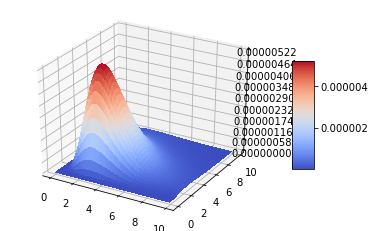

t1= 2.7
t2= 2.7


In [261]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(0, 10, 0.1)
Y = np.arange(0,10, 0.1)
X, Y = np.meshgrid(X, Y)
Z = L(rho,(X,Y),PAIR,(1,12))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(0, 0.000005)
ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

max_Z=np.argmax(Z)
print('t1=',X.flatten()[max_Z])
print('t2=',Y.flatten()[max_Z])

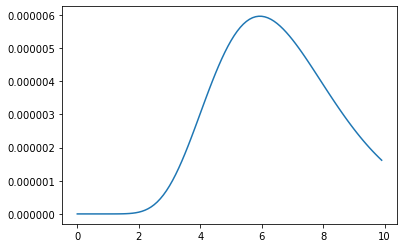

rho= 5.9


In [280]:
fig, ax = plt.subplots()

# Make data.
T = (2.7,2.7)
X = np.arange(0,10, 0.1)
# X, Y = np.meshgrid(X, Y)
Y = (L(X,T,PAIR,(1,12)))

# Plot the surface.
# surf = ax.plot_surface(X, Y,Z=0, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.plot(X, Y, label='curve in (x,y)')

# Customize the z axis.
# ax.set_zlim(0, 0.000005)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

max_Y=np.argmax(Y)
print('rho=',X.flatten()[max_Y])


$$L(ρ, t|S)= \prod_{i=1,...,{k \choose 2}}L(ρ, t_i|s_i)$$

In [17]:
import itertools
from CRISPR_functions import is_overlapping,CRISPR_pair
from scipy.optimize import minimize

arrays=[[9,2,3,4,5],[0,1,2,3,7,8],[1,10,11,12,13]]
overlapping_arrays=[pair for pair in list(itertools.combinations(arrays,2)) if is_overlapping(pair[0],pair[1])==1]
rho=5
size_lims=[1,12]


t1t2_list=[]
pair_list=[]
for pair in overlapping_arrays:
    PAIR=CRISPR_pair(pair[0],pair[1])
    
    pair_list+=[PAIR]
    t1t2_list+=[tuple(minimize(LL_floating_t,[1,1],method='Powell',args=(rho,PAIR,size_lims)).x)]
t1t2_list
pair_list

def LL_floating_rho(x,t1t2_list,pair_list,size_lims):
    return(sum([-np.log(L(x,t1t2_list[i],pair_list[i],size_lims)) for i in range(len(pair_list))]))

print(minimize(LL_floating_rho,[2],method='Powell',args=(t1t2_list,pair_list,size_lims)).x)
# LL_floating_rho(rho,t1t2_list,pair_list)


NameError: name 'LL_floating_t' is not defined

In [42]:
def OPTIMIZE_rho(t1t2_list,pair_list,size_lims):
    return(float(minimize(LL_floating_rho,[2],method='Powell',args=(t1t2_list,pair_list,size_lims)).x))

def OPTIMIZE_t1t2(overlapping_arrays,size_lims):
    t1t2_list=[]

    for pair in overlapping_arrays:
        PAIR=CRISPR_pair(pair[0],pair[1])
        t1t2_list+=[tuple(minimize(LL_floating_t,[1,1],method='Powell',args=(rho,PAIR,size_lims)).x)]
    
    return(t1t2_list)
    

In [43]:
OPTIMIZE_rho(t1t2_list,pair_list,size_lims)

/Users/maeperez/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


7.225915758817064

In [44]:
OPTIMIZE_t1t2(overlapping_arrays,size_lims)

[(2.6837588747545005, 2.683324575778658),
 (4.419151963274205, 4.436784498519175)]

In [ ]:
## take into account arrays that dont overlap


In [6]:
import itertools
from CRISPR_functions import is_overlapping

arrays=[[9,2,3,4,5],[0,1,2,3,7,8],[1,10,11,12,13],[14,15]]
non_overlapping_arrays=[pair for pair in list(itertools.combinations(arrays,2)) if is_overlapping(pair[0],pair[1])==0]



In [22]:
from CRISPR_functions import prob_n_given_ro,L
import numpy as np
rho=6
print(non_overlapping_arrays)


sum([-np.log(prob_n_given_ro(len(pair[0]),rho)*prob_n_given_ro(len(pair[1]),rho)) for pair in non_overlapping_arrays])

[([9, 2, 3, 4, 5], [1, 10, 11, 12, 13]), ([9, 2, 3, 4, 5], [14, 15]), ([0, 1, 2, 3, 7, 8], [14, 15]), ([1, 10, 11, 12, 13], [14, 15])]


18.472356709520355

In [27]:
def neg_LL_floating_rho(x,t1t2_list,pair_list,size_lims,non_non_overlapping_arrays):
    import numpy as np
    
    return(sum([-np.log(L(rho=x,t=t1t2_list[i],PAIR=pair_list[i],size_lims=size_lims)) for i in range(len(pair_list))])+sum([-np.log(prob_n_given_ro(len(pair[0]),x)*prob_n_given_ro(len(pair[1]),x)) for pair in non_overlapping_arrays]))


def OPTIMIZE_rho(t1t2_list,pair_list,size_lims,non_overlapping_arrays):
    from scipy.optimize import minimize
    return(float(minimize(neg_LL_floating_rho,[2],method='Powell',args=(t1t2_list,pair_list,size_lims,non_overlapping_arrays)).x))

# OPTIMIZE_rho(t1t2_list,pair_list,size_lims,non_overlapping_arrays)

# To do next time: 
## Check convergence function
## deal with RuntimeWarning: divide by zero encountered in log
## incorporate mpmath for more getting more precise floats
## Parallelize

# PSEUDO CODE FOR THE FULL ALGORITHM

## 1. Load packages I need
numpy
CRISPR_functions
itertools combinations
scipy
mppath; define float precision

## 2. Get variables that won't need to be updated

List of pairs with overlaps
List of pais with no overlaps
Ancestor size limits
rho_init

List of ancestors for each overlapping pair (parallelize)

## 3 Estimate t1,t2 (parallelize)
get t1,t2 list
## 4 Estimate rho
outputs rho + -LL
check for convergence
## Repeat step 3, 4


In [44]:
from mpmath import mpf,mp

mp.dps = 100
mu=mpf(1)
t=mpf(6)
mu/t
t/mu
rho=mpf(6)
n=mpf(4)

prob_n_given_ro(n,rho)
np.exp(mu)

TypeError: loop of ufunc does not support argument 0 of type mpf which has no callable exp method

In [70]:
from numpy import math
np.math.factorial(2)

from mpmath import findroot


In [71]:
def L(rho,t,PAIR,size_lims):
    '''The likelihood of a pair of spacer arrays (s1, s2) with
times (t1, t2) anf rho'''
    from CRISPR_functions import prob_n_given_ro, combi, CRISPR_pair, M, I, D
    from mpmath import mpf
    if not isinstance(rho, mpf):
        print(str(rho)+' '+ str(type(rho)))
    
    t1=t[0]
    t2=t[1]
    l1=size_lims[0]
    l2=size_lims[1]
    lbda=rho/(rho+1)
    mu=1/(rho+1)
    
    ancestors_dic= PAIR.get_combi(size_lims)
    Likelihood=0
    
    for s0,ws in ancestors_dic.items():
        combi_s0 = combi(list(map(int,s0.split('-'))))
        n=combi_s0.n

        m1,d1,j1,m2,d2,j2 = combi_s0.compare_ancestor_to_arrays(PAIR)

        Qa = prob_n_given_ro(n,rho)*ws
        T1 = M(m1,t1,mu)*D(d1,t1,mu)*I(j1,t1,lbda,mu)
        T2 = M(m2,t2,mu)*D(d2,t2,mu)*I(j2,t2,lbda,mu)
        
        Likelihood += Qa*T1*T2
    
    return(Likelihood)

import CRISPR_functions
from CRISPR_functions import CRISPR_pair
import importlib
importlib.reload(CRISPR_functions) 

rho=3
PAIR=CRISPR_pair([9,2,3,4,5],[0,1,2,3,7,8])
size_lims=(0,12)
t=(2,2)
L(rho,t,PAIR,size_lims)

3 <class 'int'>


0.000001037508416030872255866458854889649509479700845193001650914267582784400443697565004723435042088354473

In [86]:
def M(m,t,mu):
    '''probability of preserving m spacers in time t : M(m|t,mu)'''
    from mpmath import mpf,mp
#     import numpy as np
    mp.dps = 100; mp.pretty = True
#     if isinstance(mu, np.ndarray) and len(x)==1:
    print('mu',mu,type(mu))
    mu=mu*mpf(1)
    print('mu_mpf',mu,type(mu))

    print('t',t,type(t))
    print('m',m,type(m))
    print('inner',-m*t*mu)
    M=mp.exp((-m*t*mu)[0])
    print('M',M,type(M))
#     M = np.frompyfunc(mp.exp(-m*t*mu))
    return(M)

t=2.5621927111282803
m=4
mu=np.array([-3.416])

M(m,t,mu)

mu [-3.416] <class 'numpy.ndarray'>
mu_mpf [-3.415999999999999925393012745189480483531951904296875] <class 'numpy.ndarray'>
t 2.5621927111282803 <class 'float'>
m 4 <class 'int'>
inner [35.00980120485682107576441618314950652012091010397941110256821856117070979053096380084753036499023438]
M 1601634723652703.88512749849075882530862053988595294772621393360031140000466744342470682400003811711 <class 'mpmath.ctx_mp_python.mpf'>


1601634723652703.88512749849075882530862053988595294772621393360031140000466744342470682400003811711

[0 1 2 3 4 5 6 7 8 9] <class 'numpy.ndarray'>
[0 1 2 3 4 5 6 7 8 9] <class 'numpy.ndarray'>


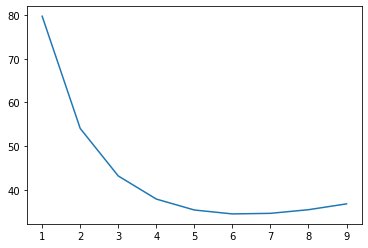

rho= 6


In [172]:
import CRISPR_functions
from CRISPR_functions import OPTIMIZE_t1t2
import importlib
importlib.reload(CRISPR_functions) 

def neg_LL_floating_rho(x,t1t2_list,pair_list,size_lims,non_overlapping_arrays):
    from mpmath import mpf,mp
    import numpy as np
    mp.dps = 100; mp.pretty = True
    
    log_array = np.frompyfunc(mp.log, 1, 1)

    neg_LL_overlapping=sum([-log_array(L(rho=x,t=t1t2_list[i],PAIR=pair_list[i],size_lims=size_lims)) for i in range(len(pair_list))])
    neg_LL_non_overlapping=sum([-log_array(prob_n_given_ro(len(pair[0]),x)*prob_n_given_ro(len(pair[1]),x)) for pair in non_overlapping_arrays])
    return(neg_LL_overlapping+neg_LL_non_overlapping)



size_lims=(1,11)
t1t2_list=[(2.5621927111282803, 2.5618452989812335), (4.1580408364803265, 4.172748284661945)]
pair_list=[CRISPR_pair(pair[0],pair[1]) for pair in overlapping_arrays]
non_overlapping_arrays=[pair for pair in list(itertools.combinations(arrays,2)) if is_overlapping(pair[0],pair[1])==0]
x=np.arange(0,10)
#x=x*mpf(1)
LLs=neg_LL_floating_rho(x,t1t2_list,pair_list,size_lims,non_overlapping_arrays)


import matplotlib.pyplot as plt
fig, ax = plt.subplots()
X=x
Y = LLs
ax.plot(X, Y, label='curve in (x,y)')

plt.show()

max_Y=np.argmin(Y)
print('rho=',X.flatten()[max_Y])